In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import math
from collections import Counter
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Data Imports

In [5]:
# Connect to my AWS server and 'project5' database
params = {
    'host': '3.130.17.136',
    'user': 'ubuntu',
    'port': 5432
}
connection = pg.connect(**params, dbname='project5')
cursor = connection.cursor()

In [9]:
# Query 'application_train' data using Postgresql
application_train_df = pd.read_sql("""

SELECT *
FROM application_train

""", connection)

In [10]:
# Turn all letters to lower case and convert the column 'sk_id_curr' to string format
application_train_df.columns = map(str.lower, application_train_df.columns)
original_column_list = list(application_train_df.columns)
application_train_df['sk_id_curr'] = application_train_df['sk_id_curr'].astype(str)
application_train_df.head(1)

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,228356,0,Cash loans,F,N,Y,0,126000.0,540000.0,25150.5,540000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.030755,-15703,-7002,-6486.0,-4622,NaN,1,1,1,1,1,0,Medicine staff,2.0,2,2,SATURDAY,9,0,0,0,0,0,0,Medicine,NaN,0.506108,0.644679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-1853.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0


In [11]:
# Show the correlation of features to the loan target value
application_train_df.corr()['target'].sort_values()

ext_source_3                   -0.178919
ext_source_2                   -0.160472
ext_source_1                   -0.155317
days_employed                  -0.044932
floorsmax_avg                  -0.044003
floorsmax_medi                 -0.043768
floorsmax_mode                 -0.043226
amt_goods_price                -0.039645
region_population_relative     -0.037227
elevators_avg                  -0.034199
elevators_medi                 -0.033863
floorsmin_avg                  -0.033614
floorsmin_medi                 -0.033394
livingarea_avg                 -0.032997
livingarea_medi                -0.032739
floorsmin_mode                 -0.032698
totalarea_mode                 -0.032596
elevators_mode                 -0.032131
livingarea_mode                -0.030685
amt_credit                     -0.030369
apartments_avg                 -0.029498
apartments_medi                -0.029184
flag_document_6                -0.028602
apartments_mode                -0.027284
livingapartments

In [12]:
# Show the unique values of every feature
for i in application_train_df.columns:
    print(i, ':', application_train_df.loc[:,i].unique())
    print(application_train_df.loc[:,i].dtypes)
    print('')

sk_id_curr : ['228356' '228357' '228358' ... '228350' '228352' '228353']
object

target : [0 1]
int64

name_contract_type : ['Cash loans' 'Revolving loans']
object

code_gender : ['F' 'M' 'XNA']
object

flag_own_car : ['N' 'Y']
object

flag_own_realty : ['Y' 'N']
object

cnt_children : [ 0  1  2  3  4  5  7 10  6  8 19 12 14  9 11]
int64

amt_income_total : [126000.  130500.  180000.  ... 411750.  119578.5 864900. ]
float64

amt_credit : [ 540000.   572076.   363190.5 ...  208408.5 1004859.  1606423.5]
float64

amt_annuity : [ 25150.5  37543.5  28822.5 ...  57501.   41490.  102384. ]
float64

amt_goods_price : [ 540000.   328500.   454500.  ...  218232.  1199308.5  208408.5]
float64

name_type_suite : ['Unaccompanied' 'Family' 'Spouse, partner' 'Other_B' 'Children' None
 'Group of people' 'Other_A']
object

name_income_type : ['Working' 'State servant' 'Pensioner' 'Commercial associate' 'Unemployed'
 'Businessman' 'Student' 'Maternity leave']
object

name_education_type : ['Secondary /

livingarea_mode : [   nan 0.4448 0.0517 ... 0.4565 0.3841 0.3726]
float64

nonlivingapartments_mode : [   nan 0.0195 0.     0.0117 0.0078 0.0039 0.1751 0.0156 0.0389 0.035
 0.0428 0.0739 0.0272 0.393  0.1128 0.5253 0.0661 0.0233 0.0623 0.1556
 0.2529 0.0545 0.0467 0.0895 0.2802 0.0584 0.0311 0.9339 0.4669 0.6226
 1.     0.07   0.0856 0.6965 0.5409 0.1634 0.3113 0.1673 0.0934 0.249
 0.0817 0.1479 0.1712 0.3268 0.0778 0.1012 0.1051 0.0506 0.3385 0.1868
 0.3969 0.323  0.1907 0.2335 0.1206 0.1167 0.284  0.9533 0.8249 0.3541
 0.1323 0.3074 0.8949 0.3852 0.1401 0.1595 0.2023 0.1362 0.1829 0.9805
 0.428  0.4319 0.2412 0.2996 0.1284 0.1089 0.2218 0.2062 0.144  0.2568
 0.1518 0.9961 0.6654 0.3346 0.7782 0.6304 0.2374 0.2763 0.3502 0.179
 0.1984 0.0973 0.3152 0.4864 0.2101 0.4358 0.5759 0.3307 0.2957 0.3891
 0.751  0.9416 0.1245 0.3424 0.2724 0.9183 0.4436 0.4942 0.2179 0.2296
 0.2879 0.4125 0.7004 0.8288 0.2451 0.6887 0.965  0.5331 0.4241 0.2257
 0.4475 0.3774 0.6615 0.4202 0.214  0.2646 0.8444

obs_60_cnt_social_circle : [  0.   1.   5.   4.   3.  10.   6.   2.   8.  18.   7.  11.  12.   9.
  nan  15.  14.  23.  13.  16.  17.  27.  21.  20.  19.  25. 344.  24.
  22.  30.  29.  26.  28.  47.]
float64

def_60_cnt_social_circle : [ 0.  1.  2.  3.  4. nan  5.  7. 24.  6.]
float64

days_last_phone_change : [-1853. -1159. -2056. ... -3697. -3390. -3458.]
float64

flag_document_2 : [0 1]
int64

flag_document_3 : [0 1]
int64

flag_document_4 : [0 1]
int64

flag_document_5 : [1 0]
int64

flag_document_6 : [0 1]
int64

flag_document_7 : [0 1]
int64

flag_document_8 : [0 1]
int64

flag_document_9 : [0 1]
int64

flag_document_10 : [0 1]
int64

flag_document_11 : [0 1]
int64

flag_document_12 : [0 1]
int64

flag_document_13 : [0 1]
int64

flag_document_14 : [0 1]
int64

flag_document_15 : [0 1]
int64

flag_document_16 : [0 1]
int64

flag_document_17 : [0 1]
int64

flag_document_18 : [0 1]
int64

flag_document_19 : [0 1]
int64

flag_document_20 : [0 1]
int64

flag_document_21 : [0 1]
int64

In [13]:
# This function shows catplot of all categorical features
def multi_catplot(df):
    for i in df.select_dtypes(['object']).columns[1:]:
        sns.catplot(y=i, kind="count", palette="ch:.25", data=df,
                height=df[i].nunique(), aspect=15/df[i].nunique(), order = df[i].value_counts().index);

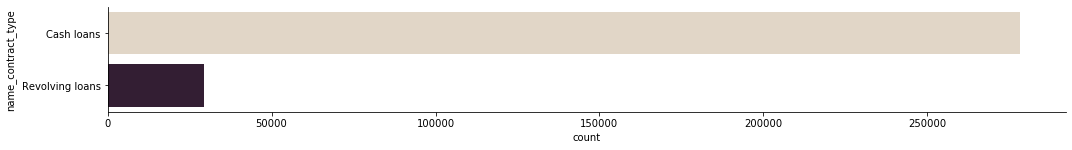

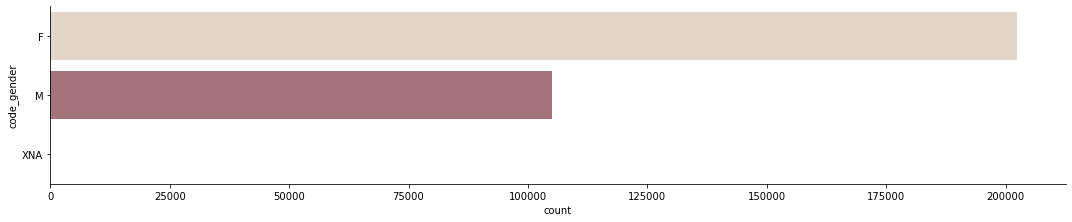

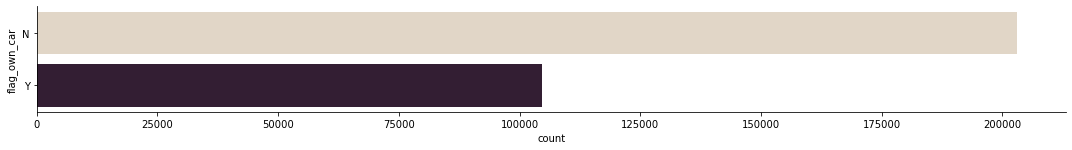

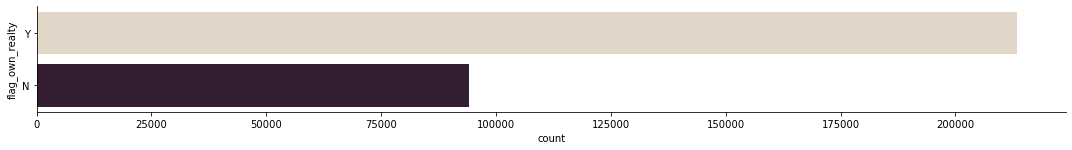

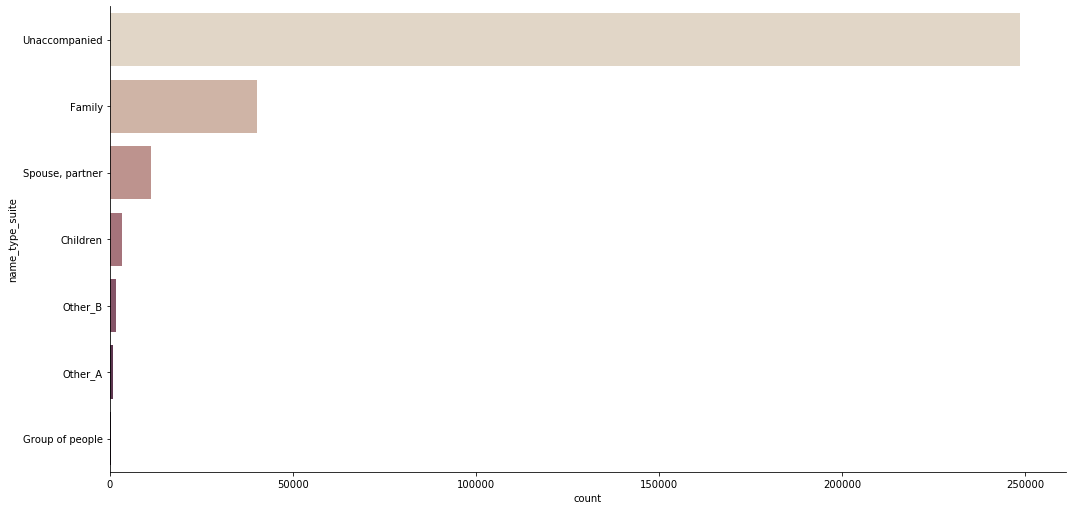

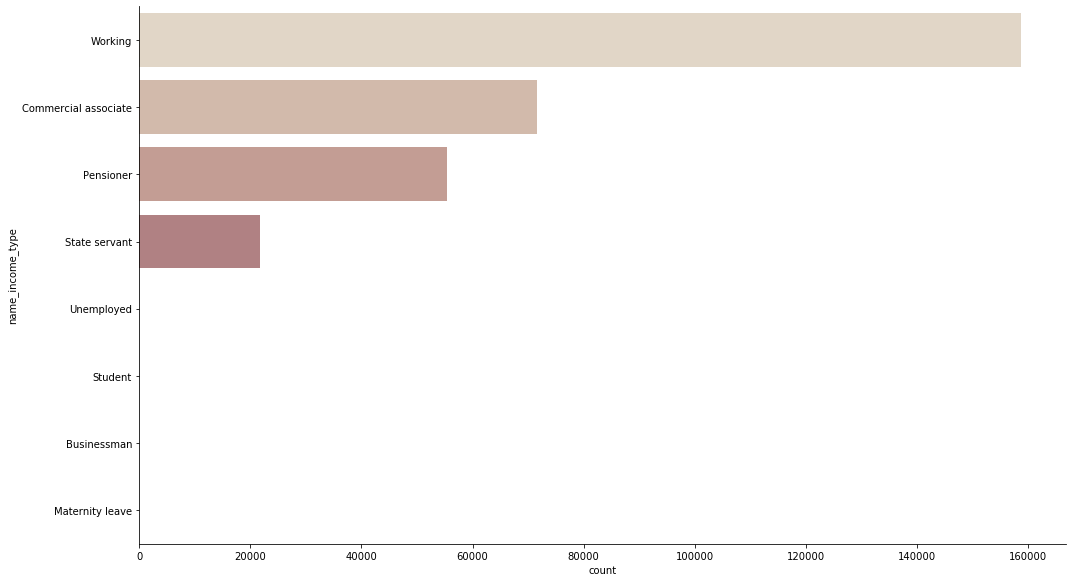

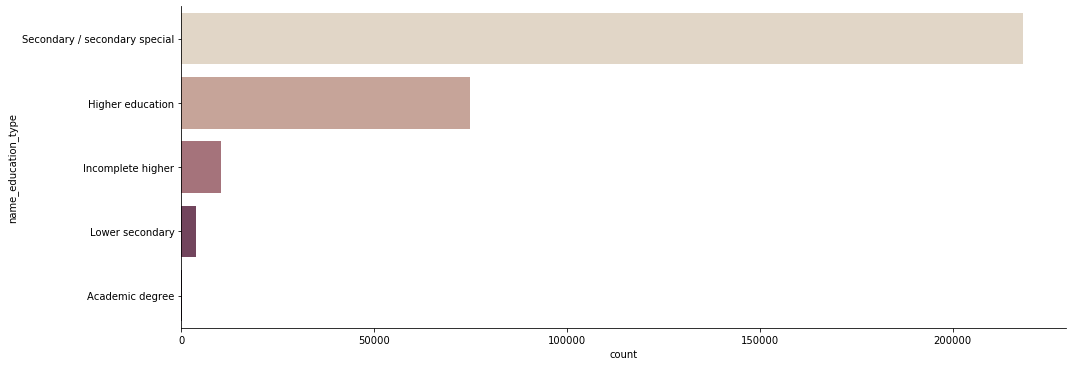

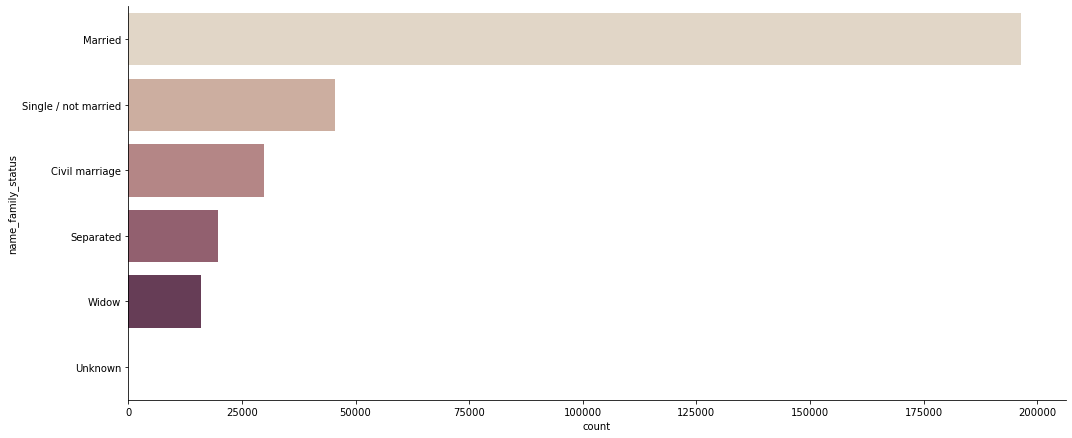

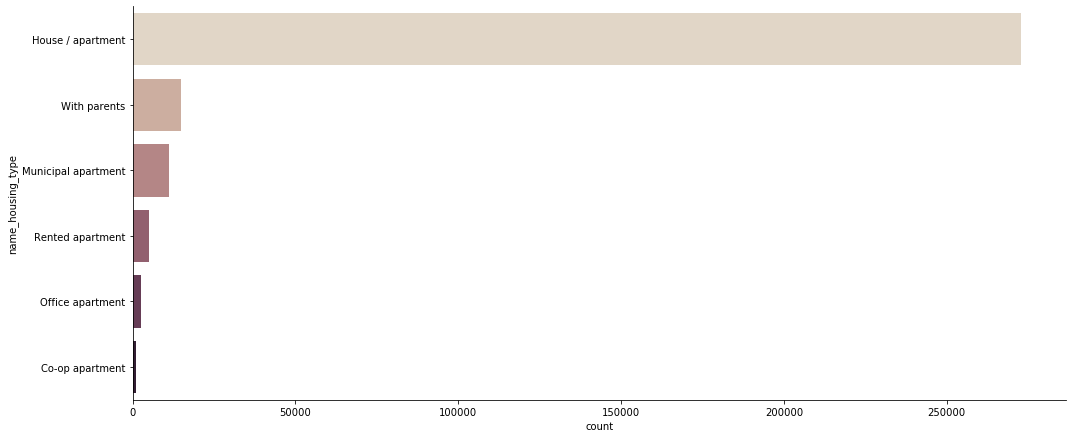

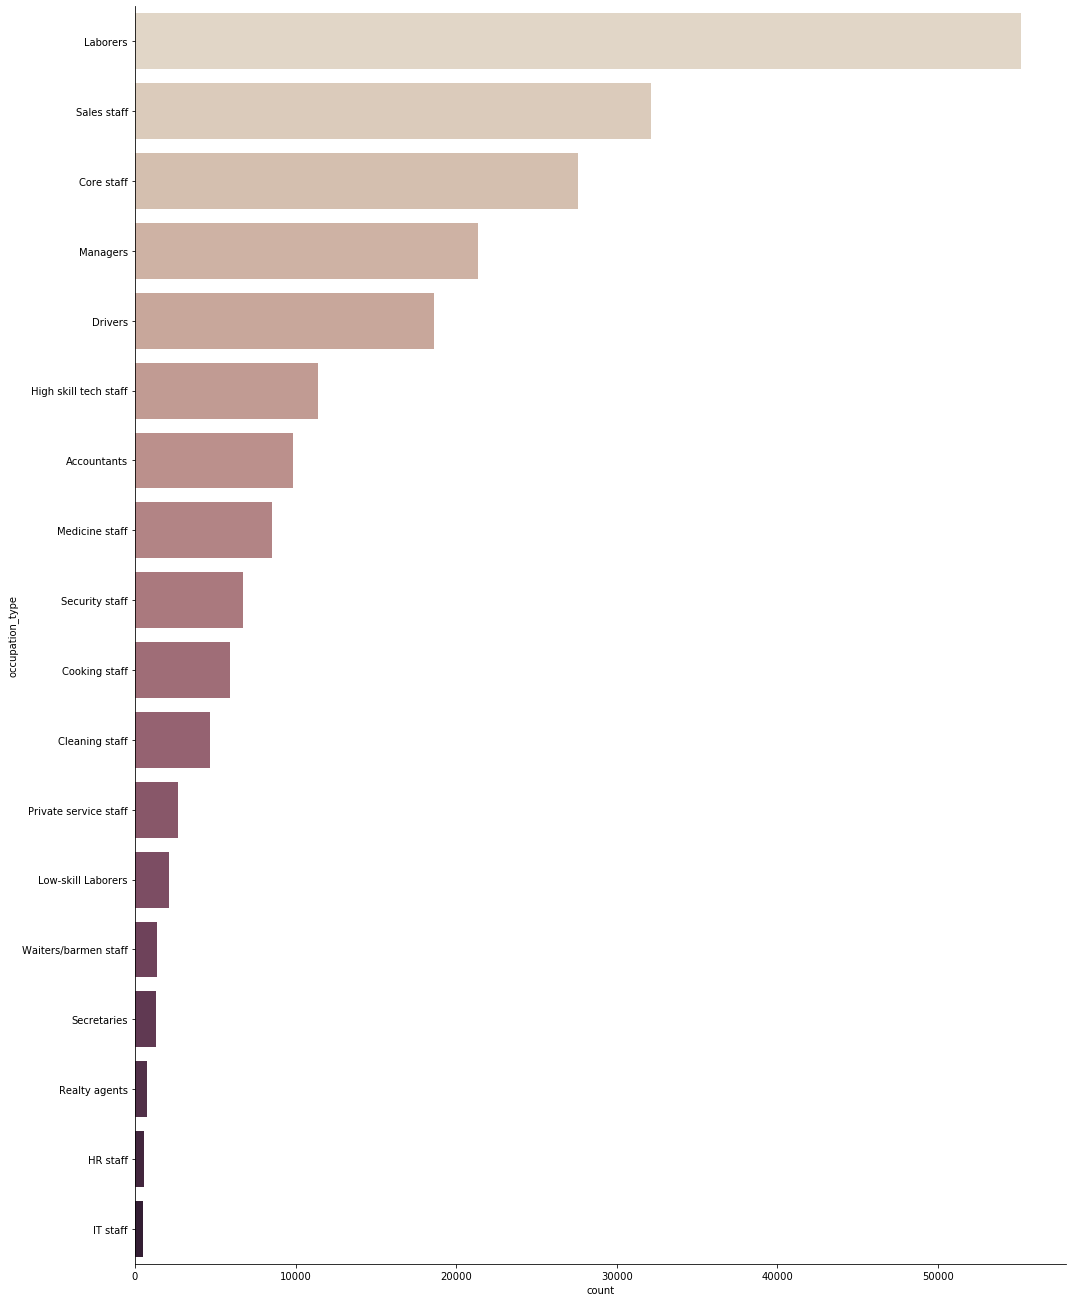

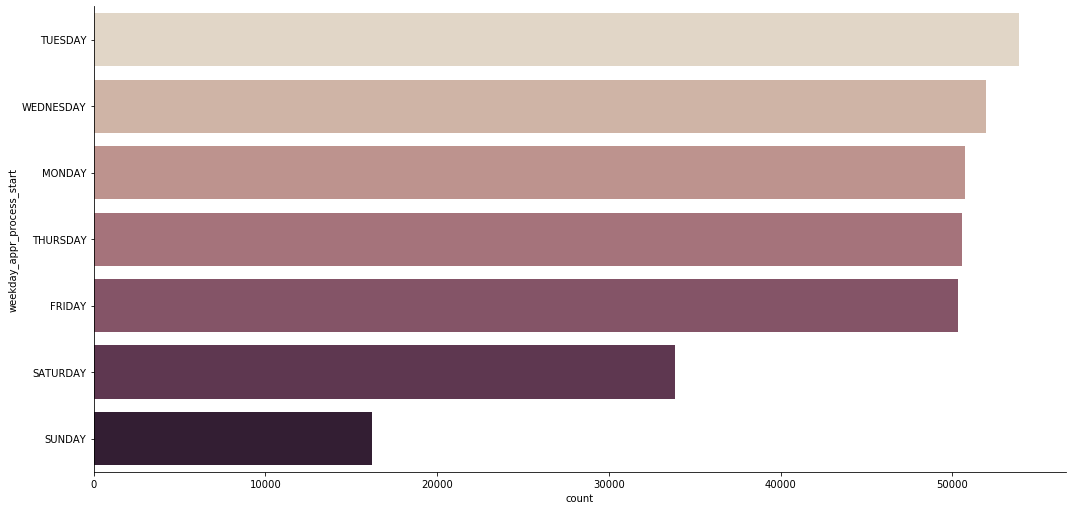

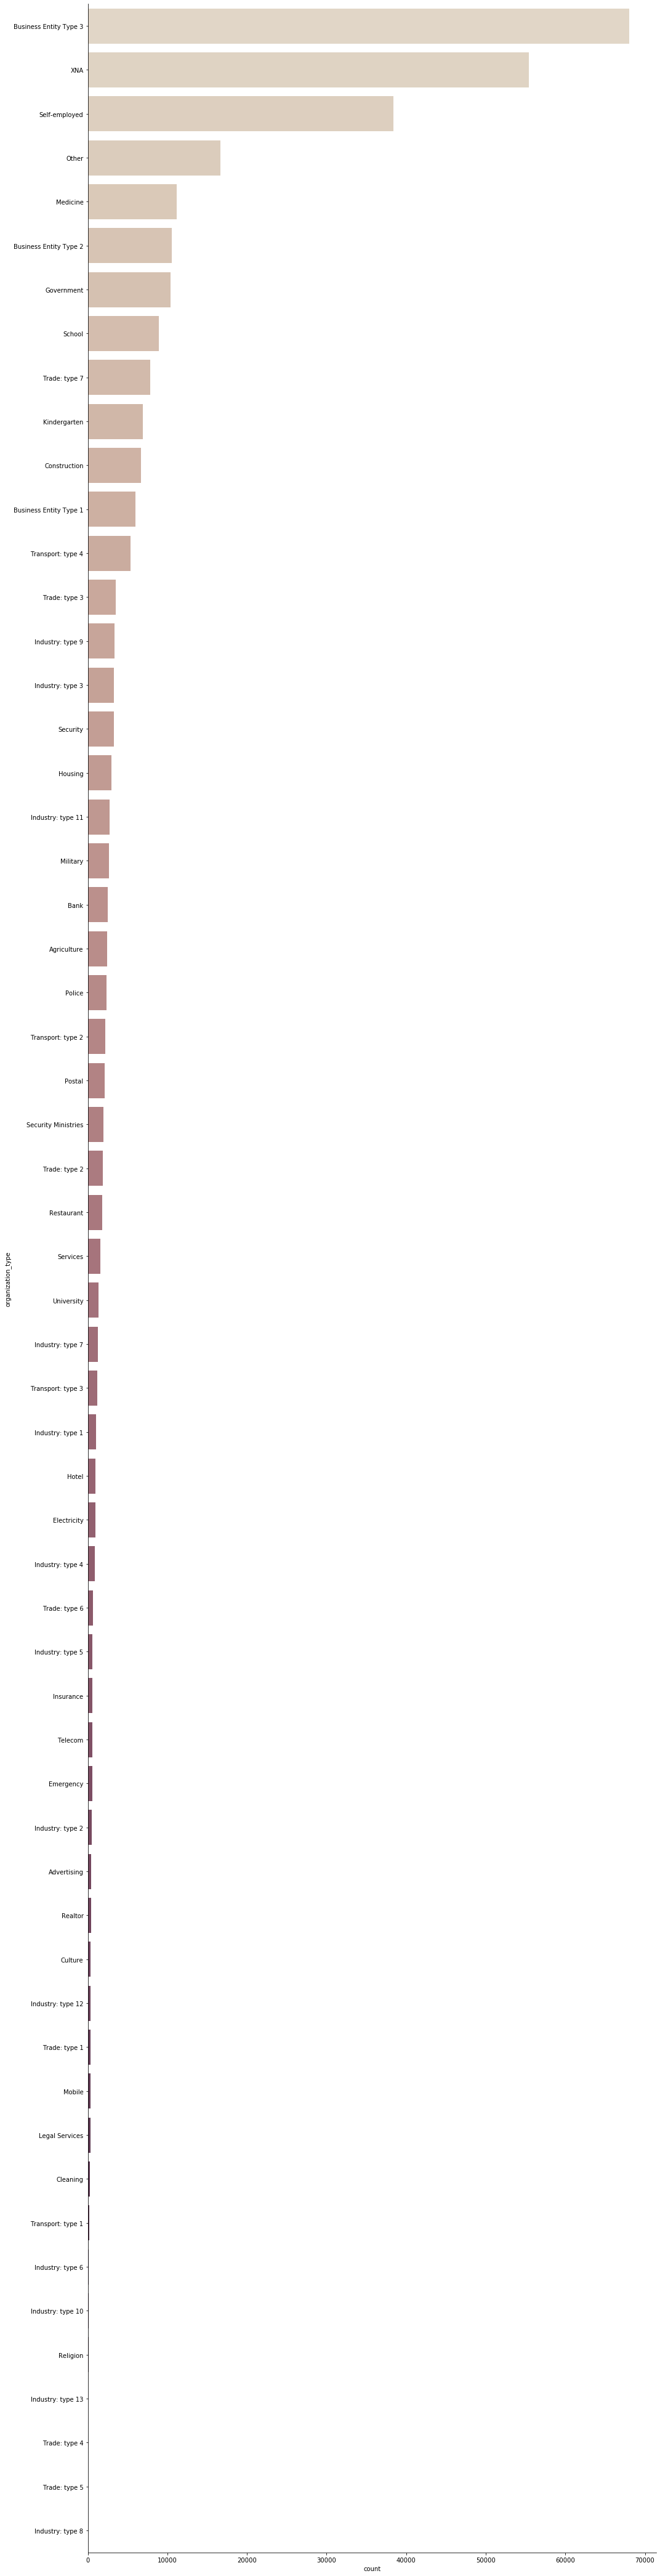

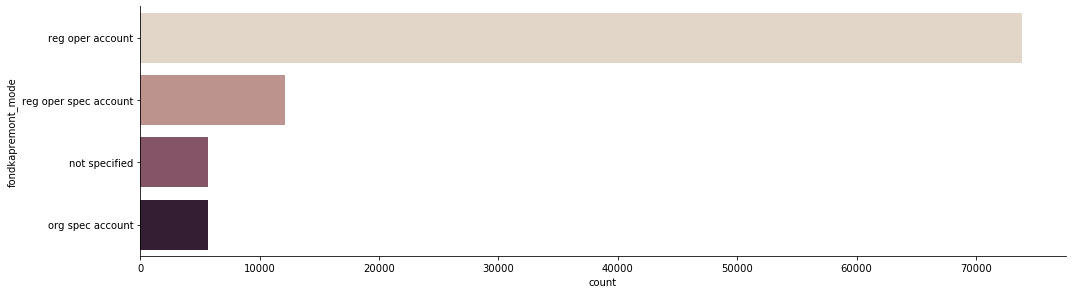

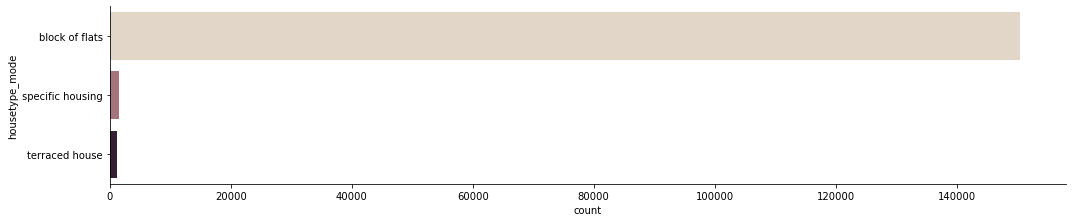

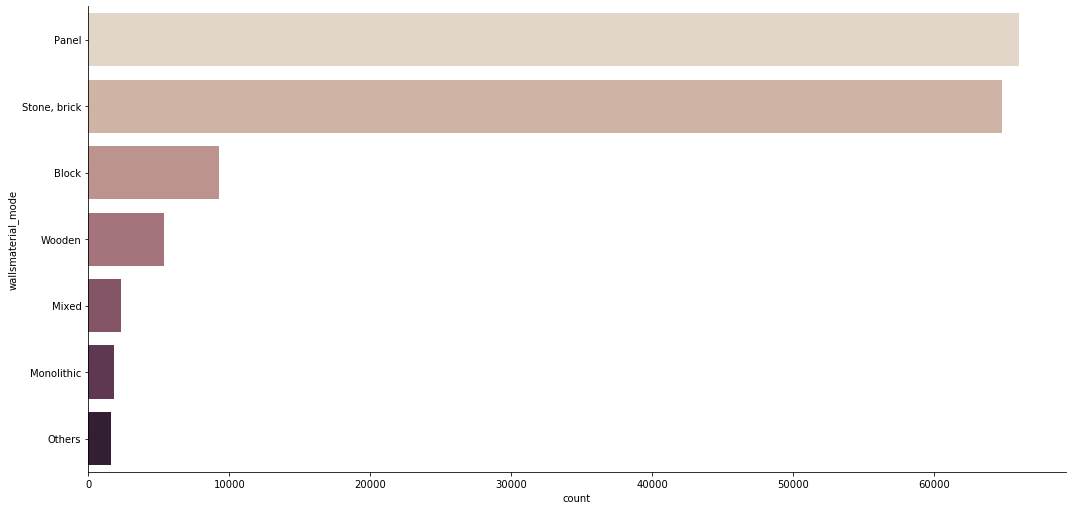

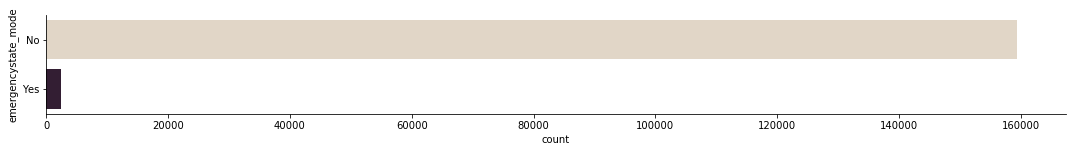

In [14]:
# Apply function multi_catplot to application_train_df
multi_catplot(application_train_df)

In [15]:
# Show the mean value of target by education type
pd.DataFrame(application_train_df.groupby('name_education_type').target.mean()).sort_values(
    by='target', ascending=False).reset_index()

,name_education_type,target
0,Lower secondary,0.109277
1,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
3,Higher education,0.053551
4,Academic degree,0.018293


In [16]:
# This function Plots the default rate for all categorical features
def cat_default_rate(df, col_size=2):
    col = col_size
    plot_num = df.select_dtypes(['object']).columns.size - 1
    row = math.ceil(plot_num / col)
    fig, axs = plt.subplots(row,col, figsize=(8*col,8*row))
    for i, col_name in enumerate(df.select_dtypes(['object']).columns[1:]):
        sns.barplot(y=col_name, x='target', data=pd.DataFrame(df.groupby(col_name).target.mean())
                    .sort_values(by='target', ascending=False).reset_index(),
                    color='maroon', ax=axs[math.floor(i/col),i%col])
    fig.tight_layout()

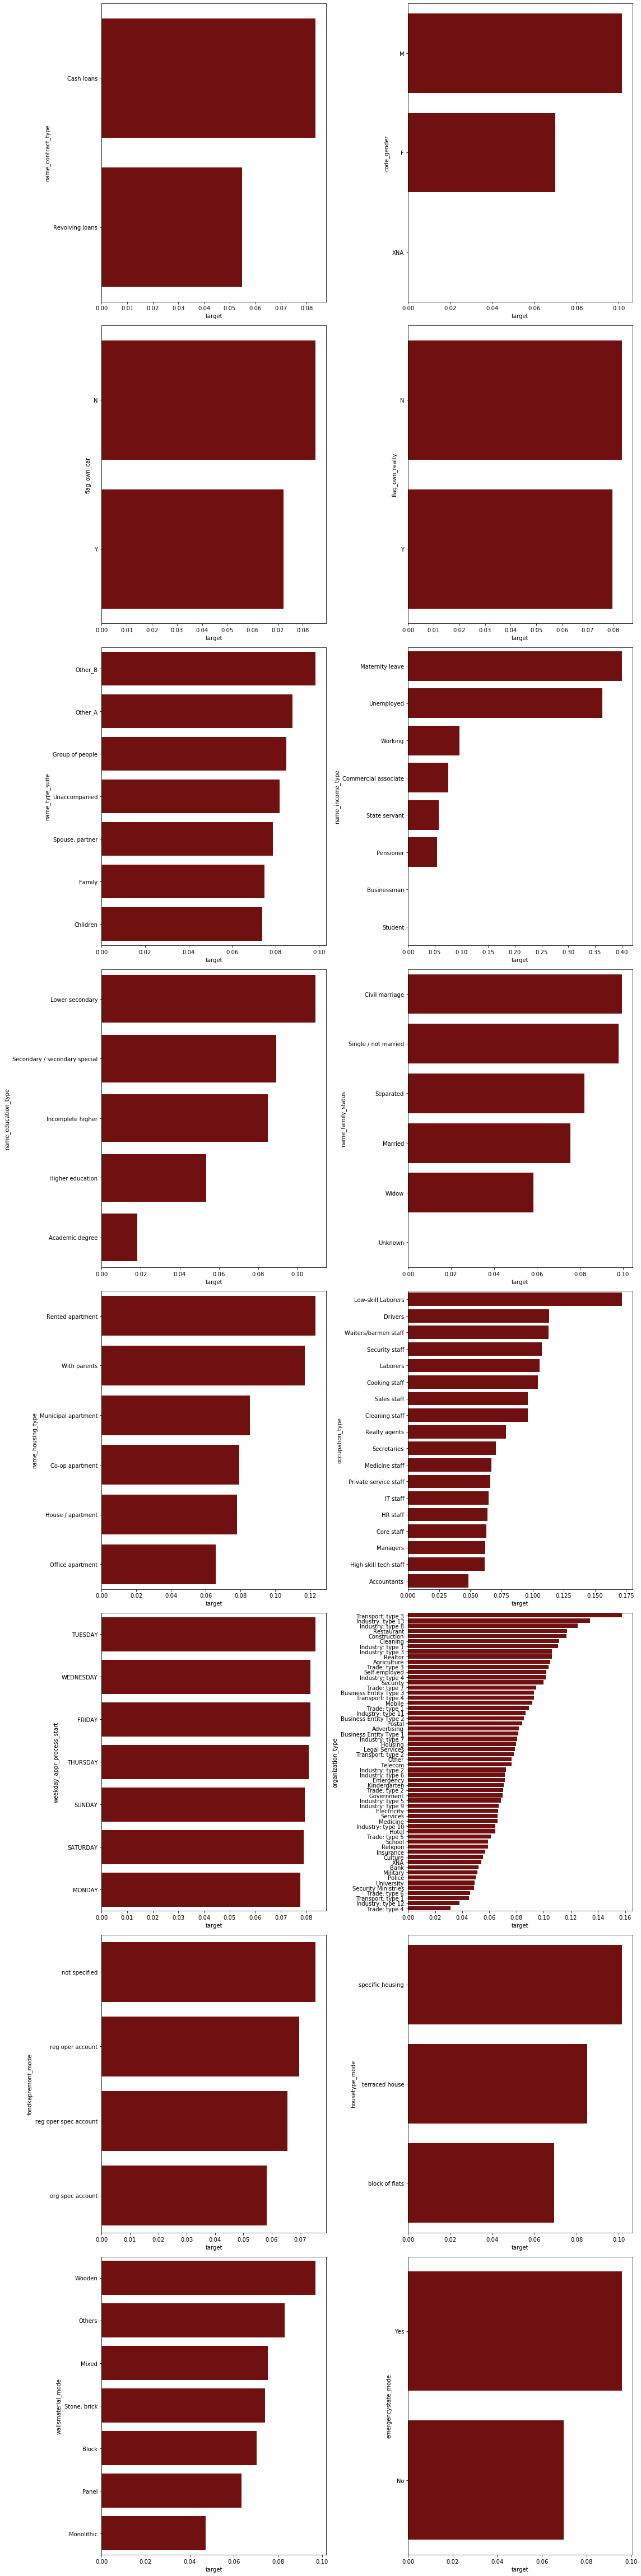

In [17]:
# Apply function cat_default_rate to application_train_df
cat_default_rate(application_train_df)

In [18]:
application_train_df.describe()

,target,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.14921

In [19]:
# This function shows distribution plots of all numerical features
def multi_numerical_distplot(df, col_size=2):
    col = col_size
    plot_num = df.select_dtypes(['int64','float64']).columns.size
    row = math.ceil(plot_num / col)
    fig, axs = plt.subplots(row,col, figsize=(8*col,5*row))
    for i, col_name in enumerate(df.select_dtypes(['int64','float64']).columns):
        nonan_values = df[col_name].dropna()
        sns.distplot(nonan_values, color='green', kde=0 ,bins=30 ,ax=axs[math.floor(i/col),i%col]);
    fig.tight_layout()

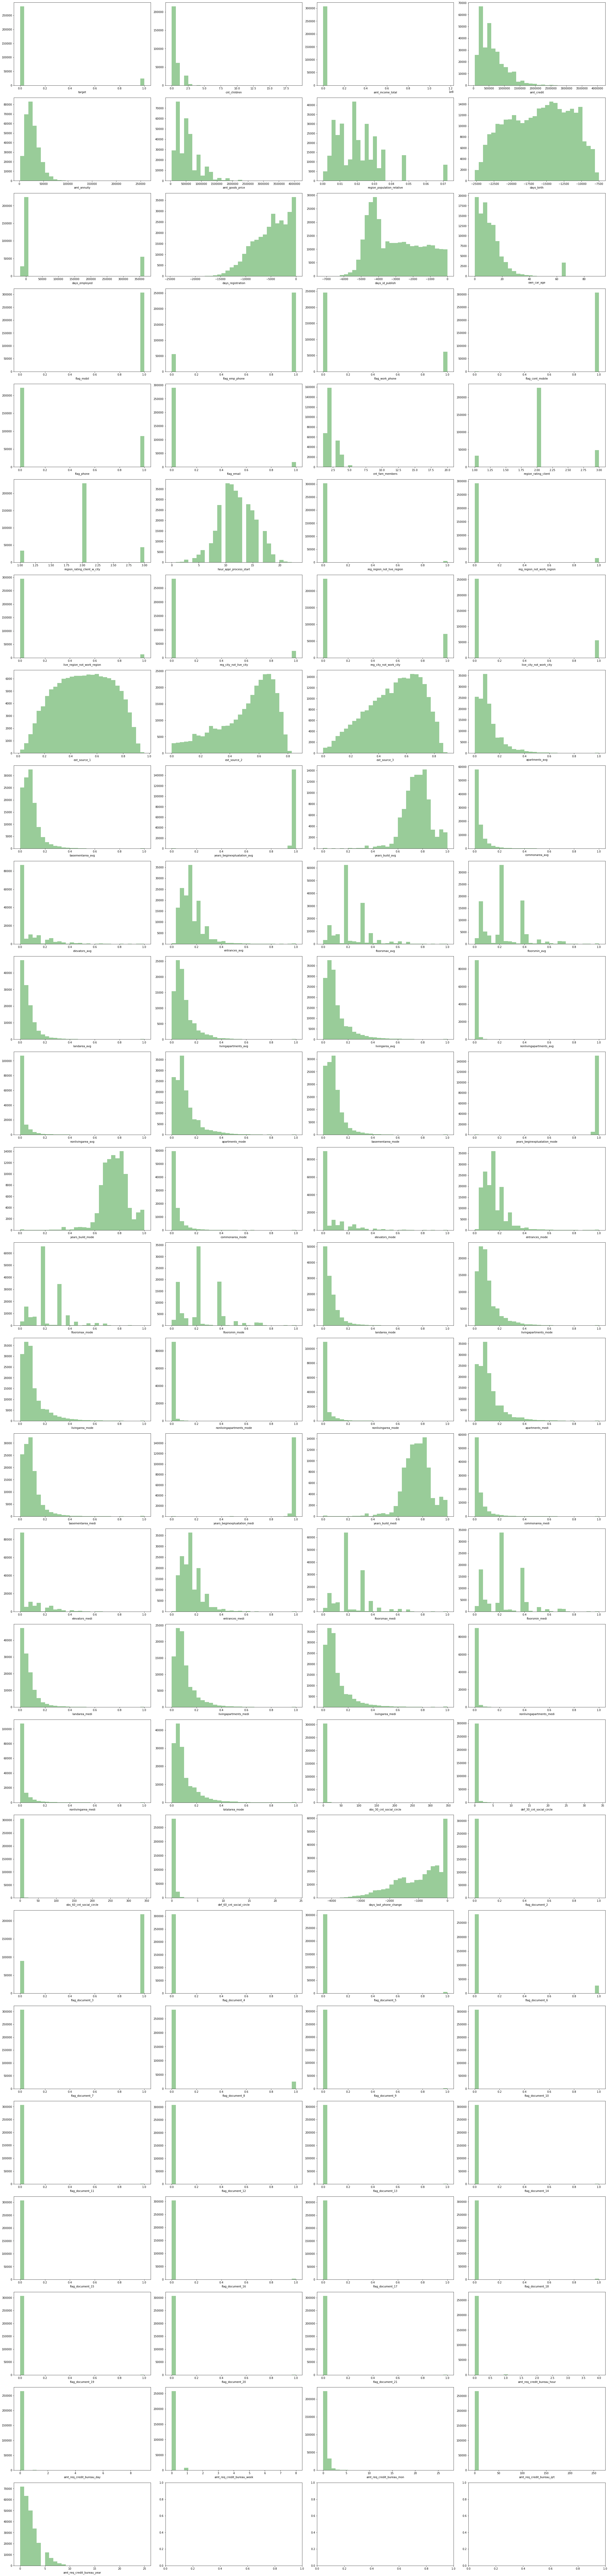

In [20]:
# Apply function multi_numerical_distplot to application_train_df
multi_numerical_distplot(application_train_df,4)